In [595]:
import pandas as pd
import sklearn as skl
from ucimlrepo import fetch_ucirepo
import math
import numpy as np
import queue
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [596]:
plt.rcParams ['figure.figsize'] = [10, 7]
sns.set();

In [2]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
df = iris.data.original

# metadata
print(iris.metadata)

# variable information
print(iris.variables)

{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Life Science', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'published_in': 'Significance, 2021', 'year': 2021, 'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e', 'doi': '1740-9713.01589'},

In [3]:
df.head(5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Сделаем исследовательский анализ данных, чтобы выявить дубликаты, пропущенные значения и неадекватные значения

In [4]:
# Посмотрим на дубликаты
df[df.duplicated(keep = False)]

,sepal length,sepal width,petal length,petal width,class
9,4.9,3.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica


In [5]:
# Уберем их из датасета, проведем проверку
df = df.drop_duplicates()

df[df.duplicated(keep = False)]

,sepal length,sepal width,petal length,petal width,class


Вывод: В результате проверки получили пустой датасет, значит дубликатов в данных не осталось

In [6]:
# Посмотрим, есть ли пропущенные значения
df.isnull().any()

sepal length    False
sepal width     False
petal length    False
petal width     False
class           False
dtype: bool

Вывод: Пропущенных значений нет

In [7]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,147.000000,147.000000,147.000000,147.000000
mean,5.856463,3.055782,3.780272,1.208844
std,0.829100,0.437009,1.759111,0.757874
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Text(0.5, 1.0, 'Гистограмма sepal length')

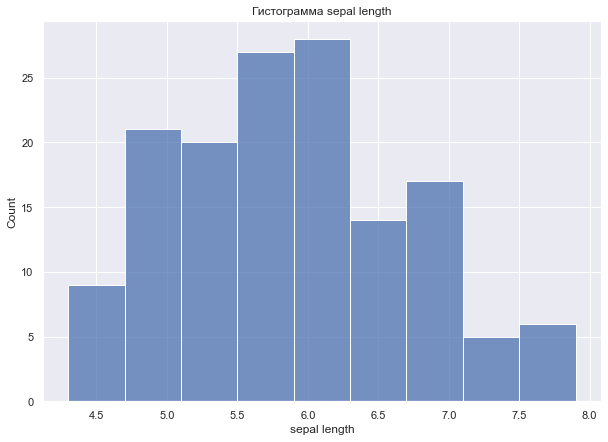

In [597]:
sns.histplot(data=df['sepal length'])

plt.title('Гистограмма sepal length')

Text(0.5, 1.0, 'Гистограмма sepal width')

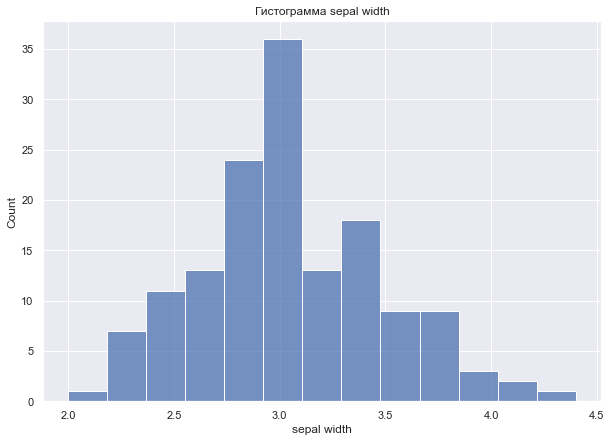

In [598]:
sns.histplot(data=df['sepal width'])
plt.title('Гистограмма sepal width')

Text(0.5, 1.0, 'Гистограмма petal length')

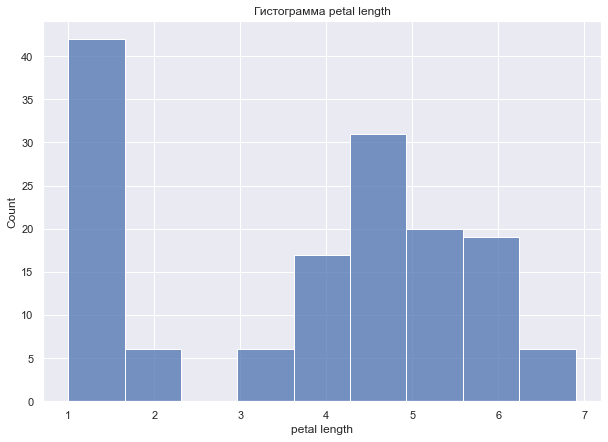

In [599]:
sns.histplot(data=df['petal length'])
plt.title('Гистограмма petal length')

Text(0.5, 1.0, 'Гистограмма petal width')

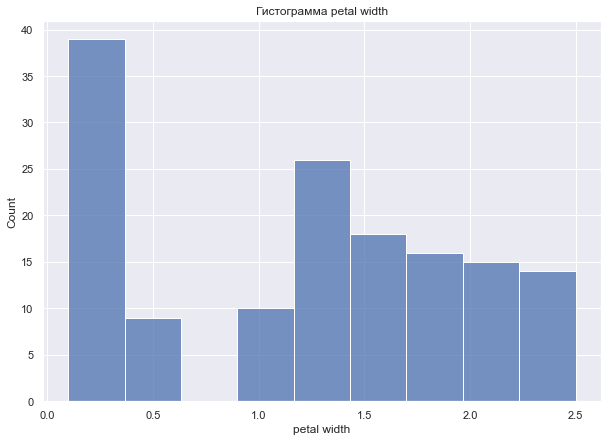

In [600]:
sns.histplot(data=df['petal width'])
plt.title('Гистограмма petal width')

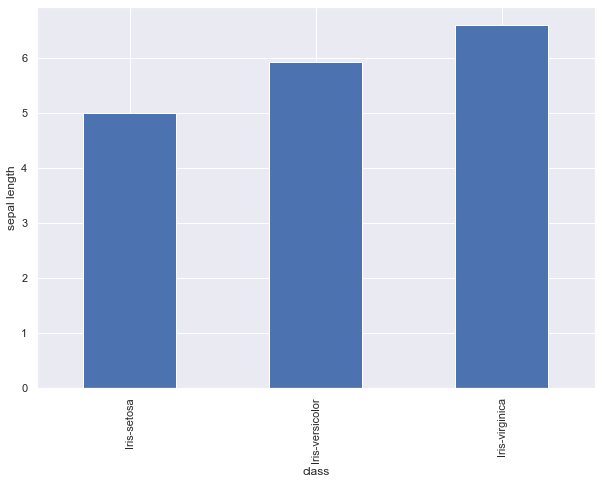

In [601]:
df.groupby('class')['sepal length'].mean().plot(kind='bar') 
plt.ylabel('sepal length') # добавляем подпись на оси Оу
plt.show();

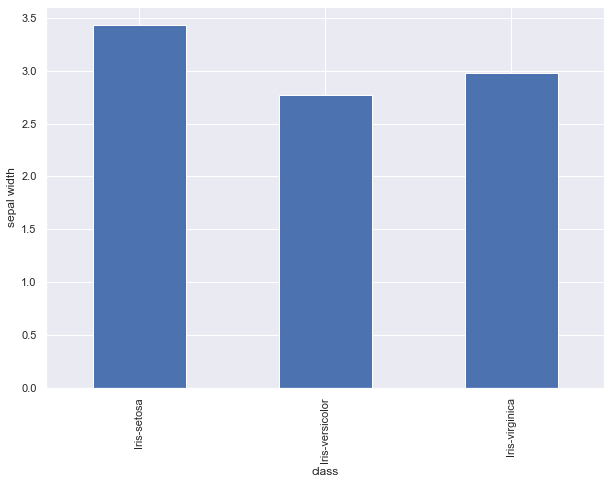

In [602]:
df.groupby('class')['sepal width'].mean().plot(kind='bar') 
plt.ylabel('sepal width') # добавляем подпись на оси Оу
plt.show();

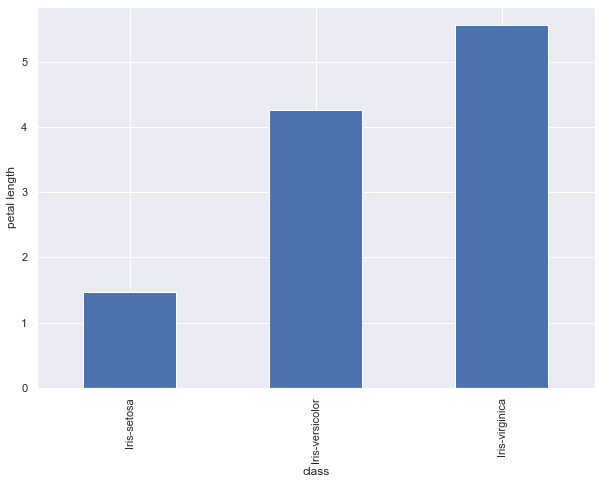

In [603]:
df.groupby('class')['petal length'].mean().plot(kind='bar') 
plt.ylabel('petal length') # добавляем подпись на оси Оу
plt.show();

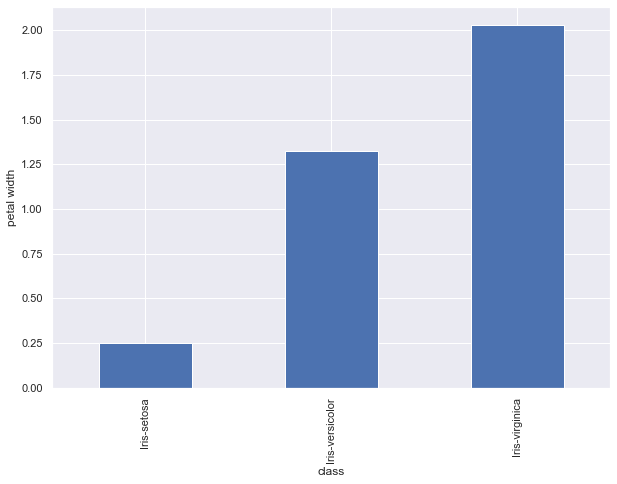

In [605]:
df.groupby('class')['petal width'].mean().plot(kind='bar') 
plt.ylabel('petal width') # добавляем подпись на оси Оу
plt.show();

<AxesSubplot:>

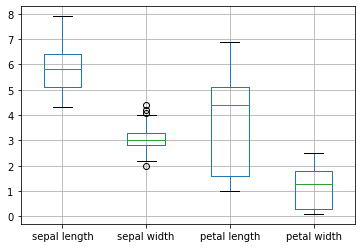

In [8]:
# Посмотрим, есть ли в датасете неадекватные значения:
df.boxplot(column = ['sepal length', 'sepal width', 'petal length', 'petal width'])

Вывод: Неадекватных значений нет (все признаки лежат выше нуля), сильных выбросов в данных нет

# Построение kNN классификатора

Разделим исходную выборку на обучающую и тестовую

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis = 1),
                                                    df['class'],
                                                    test_size = 0.2,
                                                    random_state = 54545)

In [529]:
## Метрики расстояния
def euclid_distance(point_1, point_2):
    return np.linalg.norm(point_1 - point_2)

def manhattan_distance(point_1, point_2):
    return sum(abs(point_1 - point_2))

## Ядра
def linear_kernel(dist, max_dist):
    return (max_dist - dist)/max_dist

def quadric_kernel(dist, max_dist):
    return (max_dist ** 2 - (dist/max_dist) ** 2)/(max_dist ** 2)

Реализация обычного KNN

In [586]:
## Влад
## Обычный KNN а также KNN с парзеновским окном, реализованный с помощью очередей с приоритетами
class MyKNearestNeighbors:
    ## TODO: Добавить KNN С Парзен-Розенблат
    def __init__(self, k, distance_metric, x_train, y_train, mode = "Standard", kernel = None, max_dist = None):
        self.k = k
        self.distance_metric = distance_metric
        self.x_train = x_train
        self.y_train = y_train
        self.mode = mode
        
        ## Parzen params
        self.kernel = kernel
        self.max_dist = max_dist
        
        
    def neighbours(self, input_x):
        if self.mode == "Standard":
            return self._neighbours_standard(input_x)
        if self.mode == "Parzen":
            return self._neighbours_parzen(input_x)
            
    
    def _neighbours_standard(self, input_x):
        heap = []
        heapq.heapify(heap)
        for x,y in zip(self.x_train, self.y_train):
            dist = self.distance_metric(input_x,x)
            heapq.heappush(heap, (-dist + np.random.normal(-1e-12,1e-12),(x,y)))
            if len(heap) > self.k:
                heapq.heappop(heap)
            
        return heap
    
    def _neighbours_parzen(self, input_x):
        #TODO: Написать вычисление соседей для KNN с Парзеновским окном
        heap = []
        heapq.heapify(heap)
        for x,y in zip(self.x_train, self.y_train):
            dist = self.distance_metric(input_x,x)
            if dist >= self.max_dist:
                continue
            heapq.heappush(heap, (-self.kernel(dist, self.max_dist) + np.random.normal(-1e-12,1e-12),(x,y)))
        return heap
    
    def predict(self, x_input):
        if self.mode == "Standard":
            return self._predict_standard(x_input)
        if self.mode == "Parzen":
            return self._predict_parzen(x_input)
        
        
    def _predict_standard(self,x_input):
        neighbours = self.neighbours(x_input)
        cnt_dict = {}
        for ngh in neighbours:
            label = ngh[1][1]
            if label in cnt_dict:
                cnt_dict[label] += 1
            else:
                cnt_dict[label] = 1
        return max(cnt_dict, key=cnt_dict.get)
    
    def _predict_parzen(self, x_input):
        neighbours = self.neighbours(x_input)
        cnt_dict = {}
        for ngh in neighbours:
            label = ngh[1][1]
            if label in cnt_dict:
                cnt_dict[label] += 1
            else:
                cnt_dict[label] = 1
        return max(cnt_dict, key=cnt_dict.get)
    
 
    def predict_dataset(self, x_test):
        res = []
        for x in x_test:
            res.append(self.predict(x))
        return np.array(res)
            

In [581]:
## Сравнение своей модели и sklearn (Влад)
def comparasion_models(kmin, kmax, my_model, distance_metric, X_train, y_train, X_test, y_test):
  stats = pd.DataFrame(columns = ['my_model','my_model_time', 'skl_model',"sklean_model_time", 'k_value'])

  for k in range (kmin, kmax+1):
    knn = KNeighborsClassifier(k).fit(X_train, y_train)
    my_knn = my_model(k, distance_metric, X_train, y_train)
    t1 = time.time()
    sk_pred = knn.predict(X_test)
    t2 = time.time()
    sklearn_time = t2 - t1
    
    t1 = time.time()
    my_pred = my_knn.predict_dataset(X_test)
    t2 = time.time()
    my_knn_time = t2 - t1

    sk_er = f1_score(y_test, sk_pred, average = 'micro')
    my_er = f1_score(y_test, my_pred, average = 'micro')
    result = {'my_model' : round(my_er, 2),
              'my_model_time': my_knn_time,
              'skl_model' : round(sk_er, 2),
              'sklean_model_time': sklearn_time,
              'k_value' : k}

    stats = pd.concat([stats, pd.DataFrame(result, index = [k])])
  return stats

## Сравнение своей модели c окном Парзена и модели из sklearn (Влад)

def comparasion_models_parzen(max_dist_lower, max_dist_upper, my_model, distance_metric, X_train, y_train, X_test, y_test):
    #TODO:Дописать функцию
  stats = pd.DataFrame(columns = ['my_model','my_model_time', 'skl_model',"sklean_model_time", 'k_value'])

  for k in range (kmin, kmax+1):
    knn = KNeighborsClassifier(k).fit(X_train, y_train)
    my_knn = my_model(k, distance_metric, X_train, y_train)
    t1 = time.time()
    sk_pred = knn.predict(X_test)
    t2 = time.time()
    sklearn_time = t2 - t1
    
    t1 = time.time()
    my_pred = my_knn.predict_dataset(X_test)
    t2 = time.time()
    my_knn_time = t2 - t1

    sk_er = f1_score(y_test, sk_pred, average = 'micro')
    my_er = f1_score(y_test, my_pred, average = 'micro')
    result = {'my_model' : round(my_er, 2),
              'my_model_time': my_knn_time,
              'skl_model' : round(sk_er, 2),
              'sklean_model_time': sklearn_time,
              'k_value' : k}

    stats = pd.concat([stats, pd.DataFrame(result, index = [k])])
  return stats

In [528]:
comparasion_models(1,20,MyKNearestNeighbors, euclid_distance, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test.to_numpy())

,my_model,my_model_time,skl_model,sklean_model_time,k_value
1,0.90,0.143027,0.90,0.007002,1
2,0.90,0.132996,0.87,0.004000,2
3,0.93,0.116007,0.93,0.002999,3
4,0.97,0.150010,0.97,0.004003,4
5,0.93,0.123027,0.93,0.003998,5
6,0.93,0.114927,0.93,0.004985,6
7,0.97,0.120048,0.93,0.002982,7
8,0.93,0.147032,0.93,0.003000,8
9,0.97,0.133385,0.97,0.004001,9
10,0.90,0.126030,0.93,0.004919,10


In [587]:
knn = MyKNearestNeighbors(None, manhattan_distance, X_train.to_numpy(), y_train,mode = "Parzen", kernel = quadric_kernel, max_dist = 1.3 )

In [588]:
knn.predict(X_test.to_numpy()[0])

'Iris-virginica'

In [589]:
y_preds = knn.predict_dataset(X_test.to_numpy())

In [590]:
sum(y_preds == y_test)

28

In [591]:
f1_score(y_test.to_numpy(),y_preds,average = 'micro' )

0.9333333333333333

In [594]:
# Наташа
# Функция, вычисляющая расстояние между двумя наблюдениями
def distance(nabl1, nabl2):
  feature_distances = []
  for i in range(nabl1.size):
    feature_distances.append((nabl1[i] - nabl2[i])**2)

  return math.sqrt(np.sum(feature_distances))

# Функцию, которая согласно расстояния подбирает k ближайших соседей, и отдает обратно их индексы в предоставленном dataset
def find_neighbours(nabl : pd.Series, X_train : pd.DataFrame, k : int) -> list:
  distances = {}
  for index, row in X_train.iterrows(): # Для каждого наблюдения из обучающей выборки
    distances[index] = (distance(nabl, row)) # Посчитаем расстояние до заданного наблюдения

  distances = pd.Series(distances)
  distances = distances.sort_values().iloc[:k]

  ix = distances.index
  return ix


class My_Knn:
  k = 1
  X_train = None
  y_train = None
  is_fitted = False

  def __init__(self, X_train, y_train, k):
    self.k = k
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X_test):
    predictions = {}
    for ix, nabl in X_test.iterrows(): # Для каждого неопознанного ириса

      nearest_neighbours_ix = find_neighbours(nabl, self.X_train, self.k) # Находим ближайших k соседей в обучающем множестве (гербарии), забираем их индексы
      mode_value = self.y_train.loc[nearest_neighbours_ix].mode()[0] # По индексам забираем модальное значение
      predictions[ix] = mode_value

    return pd.Series(predictions)

In [592]:
def explore_optimal_k(kmin, kmax):
  stats = pd.DataFrame(columns = ['my_model', 'skl_model', 'k_value'])

  for k in range (kmin, kmax+1):
    knn = KNeighborsClassifier(k).fit(X_train, y_train)
    my_knn = My_Knn(X_train, y_train, k)

    sk_pred = knn.predict(X_test)
    my_pred = my_knn.predict(X_test)

    sk_er = f1_score(y_test, sk_pred, average = 'micro')
    my_er = f1_score(y_test, my_pred, average = 'micro')
    result = {'skl_model' : round(sk_er, 2),
              'my_model' : round(my_er, 2),
              'k_value' : k}

    stats = pd.concat([stats, pd.DataFrame(result, index = [k])])
  return stats

explore_optimal_k(1, 20)

,my_model,skl_model,k_value
1,0.90,0.90,1
2,0.87,0.87,2
3,0.93,0.93,3
4,0.97,0.97,4
5,0.93,0.93,5
6,0.93,0.93,6
7,0.93,0.93,7
8,0.93,0.93,8
9,0.97,0.97,9
10,0.93,0.93,10


Вывод: Качество нашей модели совпадает с качеством модели scikit-learn, впервые значение оценки F1-score = 0.97 впервые встретилось при k = 4, поэтому 4 соседа — это оптимально.